In [5]:
import numpy as np
import torch
import random

In [6]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [11]:
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import ipywidgets as widgets


# latex text in plots
usetex = False
if usetex:
    rc('text', usetex=True)
else:
    rc('text', usetex=False)

#change plt parameter globally 
plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16})

In [28]:
parent = "_trainings"
childs = os.listdir(parent)

In [31]:
widget = widgets.Dropdown(
    options=childs,
    description='Directory:',
    disabled=False,
)
widget

Dropdown(description='Directory:', options=('09-09_13-13', '08-09_18-16_deprecated'), value='09-09_13-13')

In [33]:
path = os.path.join(parent, widget.value)
print("Load results from ", path)

Load results from  _trainings/09-09_13-13


In [34]:
loss = np.load(os.path.join(path, "loss.npy"))
dce = np.load(os.path.join(path, "dce.npy"))
loss_val = np.load(os.path.join(path, "loss_val.npy"))
dce_val = np.load(os.path.join(path, "dce_val.npy"))

Total number of epochs:  100


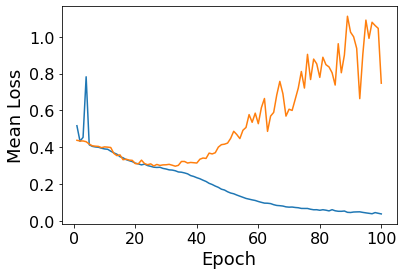

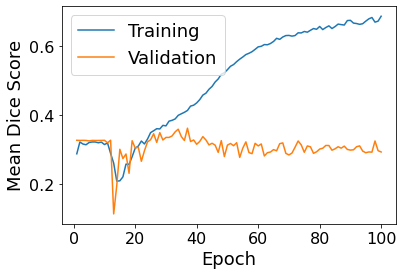

In [52]:
n_ep = len(loss)
epochs = np.arange(1,n_ep+1)
print("Total number of epochs: ", n_ep)
plt.figure()
plt.plot(epochs, loss, label="Training")
plt.plot(epochs, loss_val, label="Validation")
#plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Loss")
plt.show()
plt.figure()
plt.plot(epochs, dce, label="Training")
plt.plot(epochs, dce_val, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Dice Score")
plt.show()

# Show Predictions

In [36]:
from datasets import LoadDataset, CustomOutput
from datasets.custom_output import image_tensor, float_mask
from torch.utils.data import DataLoader

loaded_data = LoadDataset("_data/preprocessed256_new", image_dtype=float,
                          label_dtype=float)

dataset = CustomOutput(loaded_data, image_tensor, float_mask)

In [37]:
# get good split of dataset -> dividable by batch_size
batch_size = 16
l = len(dataset)
x = l // (batch_size *6 )
split = [x * batch_size * 5, l - x * batch_size * 5]
print(split)
train_set, val_set = torch.utils.data.random_split(dataset, split)

[5200, 1134]


In [38]:
dataloader_train = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=0)#, pin_memory = True)
dataloader_val = DataLoader(val_set, batch_size=batch_size,
                        shuffle=True, num_workers=0, pin_memory = True)

In [39]:
from network.unet import Unet
from network.Model import OurModel
import torch.nn as nn

In [40]:
criterion = nn.BCELoss().cuda() # use binary cross entropy loss!
network = Unet()

In [45]:
Model = OurModel(name = "unet", network= network, criterion= criterion, path_dir = path, lr = 0.001,
                 verbose = True, segmentation=True)
Model.load_weights(f"/unet_e100.ckpt")

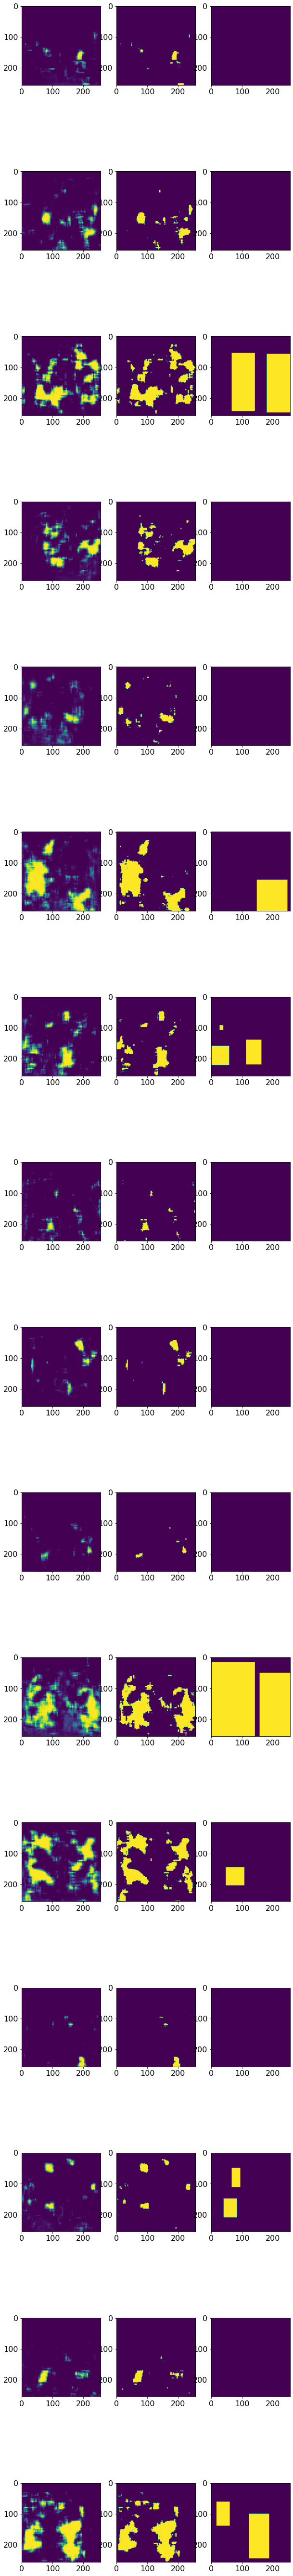

In [44]:
for x,y in dataloader_val:
    Model.network.eval()
    y_hat = Model.network(x.float().cuda())
    break

y_hat = y_hat.cpu()
y_hat = y_hat.detach().numpy()
y = y.numpy()
fig, ax = plt.subplots(len(y_hat),3, figsize=(10, 100))
for i in range(len(y_hat)):
    ax[i,0].imshow(y_hat[i])
    ax[i,1].imshow(np.round(y_hat[i]))
    ax[i,2].imshow(y[i])

In [47]:
x.max()

tensor(255., dtype=torch.float64)